# Simulation Demonstration

This notebook demonstrates the construction of a control system using the node based model, and the simulation of the system.

In [1]:
#importing the simulation, filterer, controller and agent classes
import sys
import math
sys.path.append('../')
from humancompatible.interconnect.simulators.simulation import Simulation
from humancompatible.interconnect.simulators.filterers.base_filterer import Filterer
from humancompatible.interconnect.simulators.controllers.base_controller import Controller
from humancompatible.interconnect.simulators.agents.base_agent import Agent
from humancompatible.interconnect.simulators.aggregators.base_aggregator import Aggregator
from humancompatible.interconnect.simulators.reference import ReferenceSignal
from humancompatible.interconnect.simulators.delay import Delay
from humancompatible.interconnect.simulators.population import Population

## Reference Signal Node

In [2]:
refSig = ReferenceSignal(name="r")
refSig.set_reference_signal(0.5)

## Aggregator Node

Aggregator nodes are the only node that can accept a many to one connection. They will combine these signals into a single signal.

The base aggregator sums all signals, but other aggregators can be created to perform other operations. These should inherit from the `Aggregator` class found in `base_aggregator.py`, overwriting the step method.

In [3]:
agg1 = Aggregator(name="+")
agg2 = Aggregator(name="+")

## Controller Node

In [4]:
cont = Controller(name="C")

## Agent & Population Node

In [5]:
def probability_function(x):
    startThreshold = -80
    endThreshold = 80
    if x < startThreshold:
        return 0
    elif x > endThreshold:
        return 1
    else:
        return (1 + math.cos(math.pi * (x - endThreshold) / (startThreshold - endThreshold))) / 2

agents = []
for i in range(3):
    agents.append(Agent(probability_function = probability_function,
                        positive_response = 1,
                        negative_response = 0))

pop = Population(name="P")
for agent in agents:
    pop.add_agent(agent)

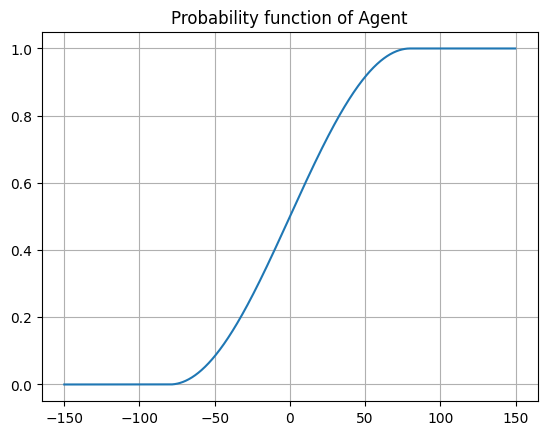

In [6]:
agents[0].plot_probability_function(-100,100)

## Delay Node

In [7]:
delay = Delay(name="Z", time=1)

## Filterer Node

In [8]:
fil = Filterer(name="F")

## Simulation

In [9]:
sim = Simulation()

### Creating the system

The system is composed of a number of nodes.

Single nodes can be added using the `system.add_node` method. Multiple nodes can be added using the `system.add_nodes` method, where a list of nodes is passed as an argument.

To connect nodes, the `system.connect` method is used. This method takes two arguments, the first being the source node and the second being the target node.

The start node, where the process begins, and the checkpoint node, where an iteration is considered complete, are added using the `system.add_start` and `system.add_checkpoint` methods, respectively.

In [10]:
sim.system.add_nodes([refSig, agg1, cont,pop, agg2, delay, fil])
sim.system.connect_nodes(refSig, agg1)
sim.system.connect_nodes(agg1, cont)
sim.system.connect_nodes(cont, pop)
sim.system.connect_nodes(pop, agg2)
sim.system.connect_nodes(agg2, delay)
sim.system.connect_nodes(delay, fil)
sim.system.connect_nodes(fil, agg1)

sim.system.set_start_node(refSig)
sim.system.set_checkpoint_node(agg1)

### Rendering the system graph

Calling the `system.render_graph()` method will produce a visualisation of the control system. This is useful for ensuring that the system has been constructed according to the desired configuration.

The start node, shaded in green, indicates where the process will begin.

The checkpoint node, shaded in blue, indicates where the iteration count will be incremented. Typically, this will be the first node in the circular path of the system.

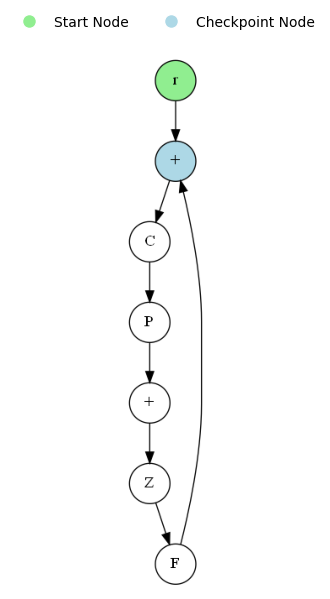

In [11]:
sim.system.render_graph()

### Checking the validity of the system

This is automatically done prior to running the simulation, but it can be done manually by calling the `check_system` method.

In [12]:
validSystem = sim.system.check_system()
if validSystem:
    print("System is valid")
else:
    for e in validSystem:
        print(e)

System is valid


### Running the simulation

In [13]:
sim.system.run(3, showTrace=True)

NODE: r
   INPUT: []
   OUTPUT: [0.5]
NODE: +
   INPUT: [[0.5], []]
   OUTPUT: [0.5]
Checkpoint: Iteration 0
NODE: C
   INPUT: [[0.5]]
   OUTPUT: [0.532299916740041]
NODE: P
   INPUT: [[0.532299916740041]]
   OUTPUT: [0, 1, 1]
NODE: +
   INPUT: [[0, 1, 1]]
   OUTPUT: [2]
NODE: Z
   INPUT: [[2]]
   OUTPUT: [2]
NODE: F
   INPUT: [[2]]
   OUTPUT: [2]
NODE: +
   INPUT: [[0.5], [2]]
   OUTPUT: [2.5]
Checkpoint: Iteration 1
NODE: C
   INPUT: [[2.5]]
   OUTPUT: [2.5649435841659542]
NODE: P
   INPUT: [[2.5649435841659542]]
   OUTPUT: [1, 0, 1]
NODE: +
   INPUT: [[1, 0, 1]]
   OUTPUT: [2]
NODE: Z
   INPUT: [[2]]
   OUTPUT: [2]
NODE: F
   INPUT: [[2]]
   OUTPUT: [2]
NODE: +
   INPUT: [[0.5], [2]]
   OUTPUT: [2.5]
Checkpoint: Iteration 2
NODE: C
   INPUT: [[2.5]]
   OUTPUT: [2.4412628681633475]
NODE: P
   INPUT: [[2.4412628681633475]]
   OUTPUT: [1, 1, 1]
NODE: +
   INPUT: [[1, 1, 1]]
   OUTPUT: [3]
NODE: Z
   INPUT: [[3]]
   OUTPUT: [3]
NODE: F
   INPUT: [[3]]
   OUTPUT: [3]
NODE: +
   INPUT: [[